In [1]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# no blurry plots!
%config InlineBackend.figure_format = 'retina'

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption style='font-weight: bold; font-size: large'>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering `%%black` at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering `%%black` at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">
    

# Part 1: SVD for learning word embeddings

This question is about word embeddings. A word embedding is a mapping from words, to vector representations of the words. Ideally, the geometry of the vectors will capture the semantic and syntactic meaning of the words—for example, words similar in meaning should have representations which are close to each other in the vector space. A good word embedding provides a means for mapping text into vectors, from which you can then apply all the usual learning algorithms that take, as input, a set of vectors. Word embeddings have taken NLP by storm in the past 5-10 years, and have become the backbone for numerous NLP tasks such as question answering and machine translation. There are neural-network approaches to learning word embeddings, but in this question we will study a simple SVD based scheme which does a surprisingly good job at learning word embeddings. 

We have created a word co-occurrence matrix $M$ of the 10,000 most frequent words from a Wikipedia corpus with 1.5 billion words. Entry $M_{ij}$ of the matrix denotes the number of times in the corpus that the $i$th and $j$th words occur within 5 words of each other. The file co_occur.csv contains the symmetric co-occurence matrix, $M$. The file dictionary.txt contains the dictionary for interpreting this matrix, the $i$th row of the dictionary is the word corresponding to the $i$th row and column of $M$. The dictionary is sorted according to the word frequencies. Therefore the first word in the dictionary—“the” is the most common word in the corpus and the first row and column of $M$ contains the co-occurrence counts of “the” with every other word in the dictionary.

</div>

In [185]:
from dataclasses import dataclass

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas._testing import assert_frame_equal
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm

from cs168.mini_project_5 import load_co_occurence_data, load_analogy_data

<div class="custom-assignment-text">
    

a. Make sure you can import the given datasets into whatever language you’re using. If you’re using MATLAB, you can import the data using the GUI. Also, make sure you can interpret the entries of the co-occurrence matrix using the dictionary, you can try to find the co-occurrence of a few pairs of common words to make sure of this.

</div>

In [3]:
CO_OCCURRENCES, DICTIONARY = load_co_occurence_data()

In [14]:
assert CO_OCCURRENCES.shape == (10_000,10_000)
assert DICTIONARY.shape == (10_000,)
ok()

<div class="custom-assignment-text">
    

b. (3 points) Let matrix $M$ denote the $10000×10000$ matrix of word co-occurrences. In light of the power law distribution of word occurrences, it is more suitable to work with the normalized matrix $\tilde{M}$ such that each entry $\tilde{M}_{ij} = log(1 + M_{ij})$. For the remainder of this problem, we will work with this scaled matrix, $\tilde{M}$. Compute the rank-100 approximation of $\tilde{M}$ by computing the SVD $\tilde{M} = UDV^\top$ . Plot the singular values of $\tilde{M}$. Does $\tilde{M}$ seem to be close to a low rank matrix? [Hint: Computing the full SVD will take a bit of time—instead you should compute just the top 100 singular values/vectors... and save this decomposition rather than recomputing every time you work on this miniproject!]

</div>

In [6]:
NORMALIZED_CO_OCCURRENCES = np.log1p(CO_OCCURRENCES)

In [7]:
@dataclass
class SVDResult:
    U: pd.DataFrame
    S: pd.DataFrame
    VT: pd.DataFrame

def decompose(data):
    U, S, VT = randomized_svd(data, 
                                  n_components=100,
                                  n_iter=5,
                                  random_state=None)
    return SVDResult(pd.DataFrame(U), pd.DataFrame(S), pd.DataFrame(VT))
    
%time CO_OCCURRENCES_SVD = decompose(NORMALIZED_CO_OCCURRENCES.to_numpy())

CPU times: user 14.9 s, sys: 380 ms, total: 15.3 s
Wall time: 8.96 s


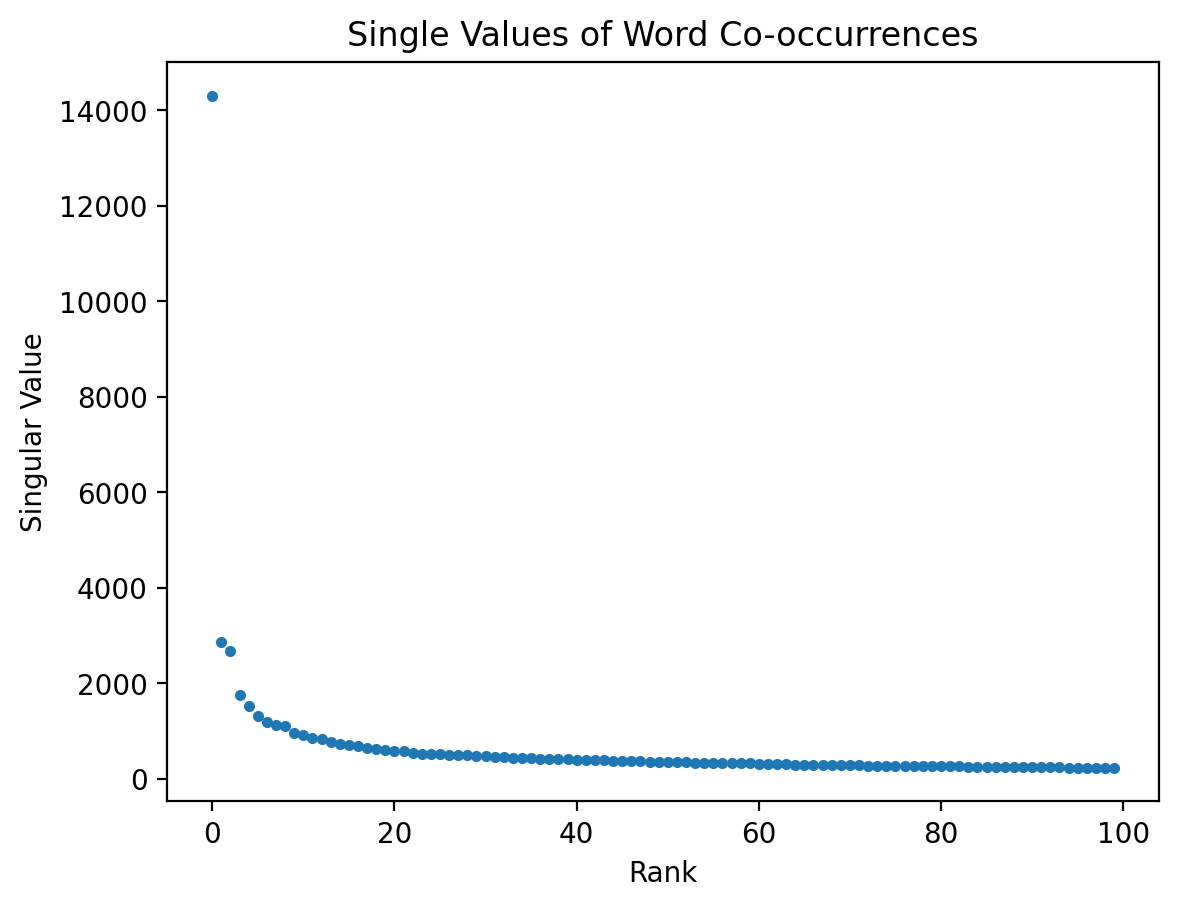

In [8]:
def plot_singular_values(svd_result):
    fig, ax = plt.subplots()
    ax.set_xlabel("Rank")
    ax.set_ylabel("Singular Value")
    ax.set_title("Single Values of Word Co-occurrences")
    ax.plot(svd_result.S, ".")

plot_singular_values(CO_OCCURRENCES_SVD)

$\tilde{M}$ does appear to be close to a low-rank matrix, as there is a quick exponential drop in the singular values after the first few largest ones.

<div class="custom-assignment-text">

c. (5 points) Note that as the matrix $\tilde{M}$ is symmetric, the left and right singular vectors are the same, up to flipping signs of some columns. We will now interpret the singular vectors (columns of $U$ or $V$ ). For any $i$, denote $v_i$ as the singular vector corresponding to the ith largest singular value. Note that the coordinates of this vector correspond to the $10,000$ words in our dictionary. For a given vector $v_i$ , you can see which words are most/least relevant for that vector by looking at the words corresponding to the coordinates of $v_i$ that have the largest or smallest values. This allows you to get a rough sense for the semantic information that is captured in each of the singular vectors. Find 5 interesting/interpretable singular vectors, and describe what semantic or syntactic structures they capture. For each of the 5 vectors you choose, provide a list of the 10 words corresponding to the coordinates with the largest values and the 10 words corresponding to the coordinates of that vector with the smallest values. Not all of the singular vectors have easy-to-interpret semantics; why would you expect this to be the case?

</div>

In [9]:
def interpret_singular_value(svd_result, dictionary, index):
    U = svd_result.U[index]
    largest_indices = U.nlargest(10).index
    smallest_indices = U.nsmallest(10).index

    return {
        "highest": dictionary[largest_indices].values.tolist(),
        "lowest": dictionary[smallest_indices].values.tolist(),
    }


def print_interpretable_singular_values():
    descriptions = [
        (3, "Governmental bodies"),
        (9, "Military"),
        (16, "Political groups"),
        (21, "TV people and settings"),
        (23, "Journalism"),
        (25, "Hispanic male first names"),
        (26, "Ill-being"),
        (30, "English male first names"),
        (73, "To a large degree"),
    ]

    table = []
    for index, description in descriptions:
        words = interpret_singular_value(CO_OCCURRENCES_SVD, DICTIONARY, index)
        row = [index, description, words["highest"], words["lowest"]]
        table.append(row)
    display_table(
        table,
        "Interpretable Singular Vectors",
        ["Index", "Description", "Largest Values", "Lowest Values"],
    )


print_interpretable_singular_values()

Index,Description,Largest Values,Lowest Values
3,Governmental bodies,"['district', 'county', 'council', 'university', 'national', 'regional', 'government', 'department', 'northern', 'municipal']","['you', 'album', 'love', 'me', 'my', 'song', 'episode', 'your', 'vocals', 'baby']"
9,Military,"['ii', 'commander', 'german', 'de', 'iii', 'squadron', 'mm', 'aircraft', 'iv', 'command']","['community', 'downtown', 'students', 'campus', 'schools', 'public', 'residents', 'neighborhood', 'college', 'park']"
16,Political groups,"['republican', 'democratic', 'conservative', 'anti', 'election', 'liberal', 'party', 'democrat', 'black', 'white']","['at', 'her', 'paris', 'she', 'maria', 'training', 'hospital', 'vienna', 'teacher', 'munich']"
21,TV people and settings,"['characters', 'television', 'location', 'character', 'actor', 'channel', 'bbc', 'plot', 'journalist', 'actress']","['lp', 'album', 'cd', 'vol', 'university', 'and', 'remix', 'records', 'band', 'institute']"
23,Journalism,"['newspaper', 'jewish', 'average', 'chicago', 'percent', 'per', 'magazine', 'estimated', 'daily', 'rate']","['act', 'scotland', 'wales', 'vocals', 'ireland', 'england', 'the', 'arrangements', 'and', 'keyboards']"
25,Hispanic male first names,"['san', 'juan', 'antonio', 'josé', 'historic', 'carlos', 'luis', 'additional', 'del', 'francisco']","['bbc', 'conservative', 'oxford', 'cambridge', 'uk', 'cricket', 'labour', 'liberal', 'ltd', 'edinburgh']"
26,Ill-being,"['disease', 'drug', 'treatment', 'patients', 'injury', 'involving', 'cancer', 'symptoms', 'cases', 'alcohol']","['award', 'its', 'outstanding', 'the', 'was', 'strategic', 'mountains', 'achievement', 'it', 'highest']"
30,English male first names,"['john', 'david', 'michael', 'william', 'robert', 'peter', 'tom', 'mike', 'george', 'richard']","['tries', 'can', 'does', 'must', 'decides', 'would', 'attempts', 'helps', 'footballer', 'designed']"
73,To a large degree,"['contains', 'containing', 'onto', 'contain', 'used', 'can', 'contained', 'designed', 'need', 'popularity']","['considerable', 'an', 'increased', 'great', 'increasing', 'greater', 'significant', 'substantial', 'currently', 'strong']"


<div class="custom-assignment-text">

d. Let $U$ denote the $10000×100$ matrix corresponding to the top 100 singular vectors. Normalize the rows of $U$ such that each row has unit $\ell_2$ norm. We will regard the $i$th row of $U$ as the (100-dimensional) embedding of the $i$th word. We will now explore a curious property of these word embedding—that certain directions in the embedded space correspond to specific syntactic or semantic concepts. Let $\mathbf{v_1}$ be the word embedding for “woman” and $\mathbf{v_2}$ be the word embedding for “man”. Let $\mathbf{v} = \mathbf{v_1} − \mathbf{v_2}$.

</div>

<div class="custom-assignment-text">

* i (5 points) Project the embeddings of the following words onto $\mathbf{v}$: boy, girl, brother, sister, king, queen, he, she, john, mary, wall, tree. Present a plot of projections of the embeddings of these words marked on a line. For example, if the projection of the embedding for “girl” onto $\mathbf{v}$ is 0.1, then you should label 0.1 on the line with “girl”. What do you observe?

</div>

In [244]:
class Embeddings:
    def __init__(self, co_occurrences_svd, dictionary):
        self.embeddings = (
            co_occurrences_svd.U.T / np.linalg.norm(co_occurrences_svd.U.values, axis=1)
        ).T
        self.dictionary = dictionary

    def get_idx_embedding(self, word):
        index = self.dictionary.index[self.dictionary == word][0]
        return (index, self.embeddings.loc[index])
    
    def get_embedding(self, word):
        index, embedding = self.get_idx_embedding(word)
        return embedding
    
    def get_n_closest(self, word, n):
        """Return the n closest words to word, measured by cosine similarity of their embeddings."""
        index, embedding = self.__get_idx_embedding(word)
        sims = embedding.dot(self.embeddings.T)
        # ignore similarity of word with itself
        sims.drop(index, inplace=True)
        closest_idx = sims.nlargest(n).index
        return self.dictionary[closest_idx].values
    
    def solve_analogy(self, a, b, c):
        """Return the word which solves the analogy problem: a is to b as c is to ____. This is done
        by finding the word with the embedding which is closest to v_a - v_b + v_c."""
        a_index, a_embedding = self.get_idx_embedding(a)
        b_index, b_embedding = self.get_idx_embedding(b)
        c_index, c_embedding = self.get_idx_embedding(c)
        
        search_embedding = a_embedding - b_embedding + c_embedding
        sims = search_embedding.dot(self.embeddings.T)
        # ignore similarity of words with a, b and c
        sims.drop([a_index, b_index, c_index], inplace=True)
        closest_idx = sims.idxmax()
        return self.dictionary[closest_idx]

In [245]:
EMBEDDINGS = Embeddings(CO_OCCURRENCES_SVD, DICTIONARY)

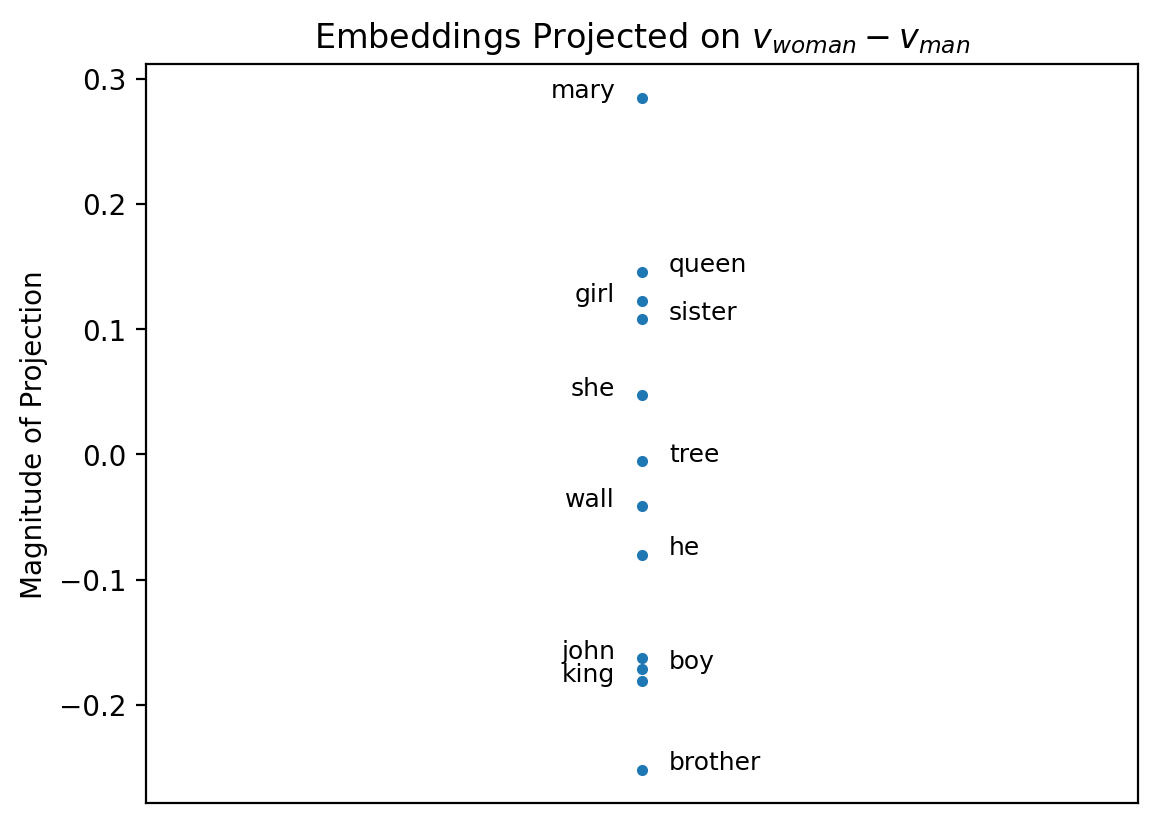

In [87]:
def plot_projections(embeddings: Embeddings, words_to_plot):
    woman_embedding = embeddings.get_embedding("woman")
    man_embedding = embeddings.get_embedding("man")
    wo_man_diff_embedding = woman_embedding - man_embedding
    assert (
        woman_embedding.shape
        == man_embedding.shape
        == wo_man_diff_embedding.shape
        == (100,)
    )

    projections = [
        (word, wo_man_diff_embedding.dot(embeddings.get_embedding(word)))
        for word in words_to_plot
    ]
    points = [
        (i, w, p) for i, (w, p) in enumerate(sorted(projections, key=lambda x: x[1]))
    ]

    fig, ax = plt.subplots()
    ax.set_ylabel("Magnitude of Projection")
    ax.set_xticks([])
    ax.set_title("Embeddings Projected on $v_{woman} - v_{man}$")

    ax.plot([0] * len(points), [p[2] for p in points], ".")
    for (i, w, p) in points:
        x = 0.003
        if i % 2 == 0:
            ha = "left"
        else:
            x *= -1
            ha = "right"
        ax.text(x, p, w, fontsize=9, ha=ha)


plot_projections(
    EMBEDDINGS,
    [
        "boy",
        "girl",
        "brother",
        "sister",
        "king",
        "queen",
        "he",
        "she",
        "john",
        "mary",
        "wall",
        "tree",
    ],
)

<div class="custom-assignment-text">

* ii (5 points) Present a similar plot of the projections of the embeddings of the following words onto $\mathbf{v}$: math, matrix, history, nurse, doctor, pilot, teacher, engineer, science, arts, literature, bob, alice. What do you observe? Why do you think this is the case? Do you see a potential problem with this? (For example, suppose LinkedIn used such word embeddings to extract information from candidates’ resumes to improve their “search for qualified job candidates” option. What might be the result of this?

</div>

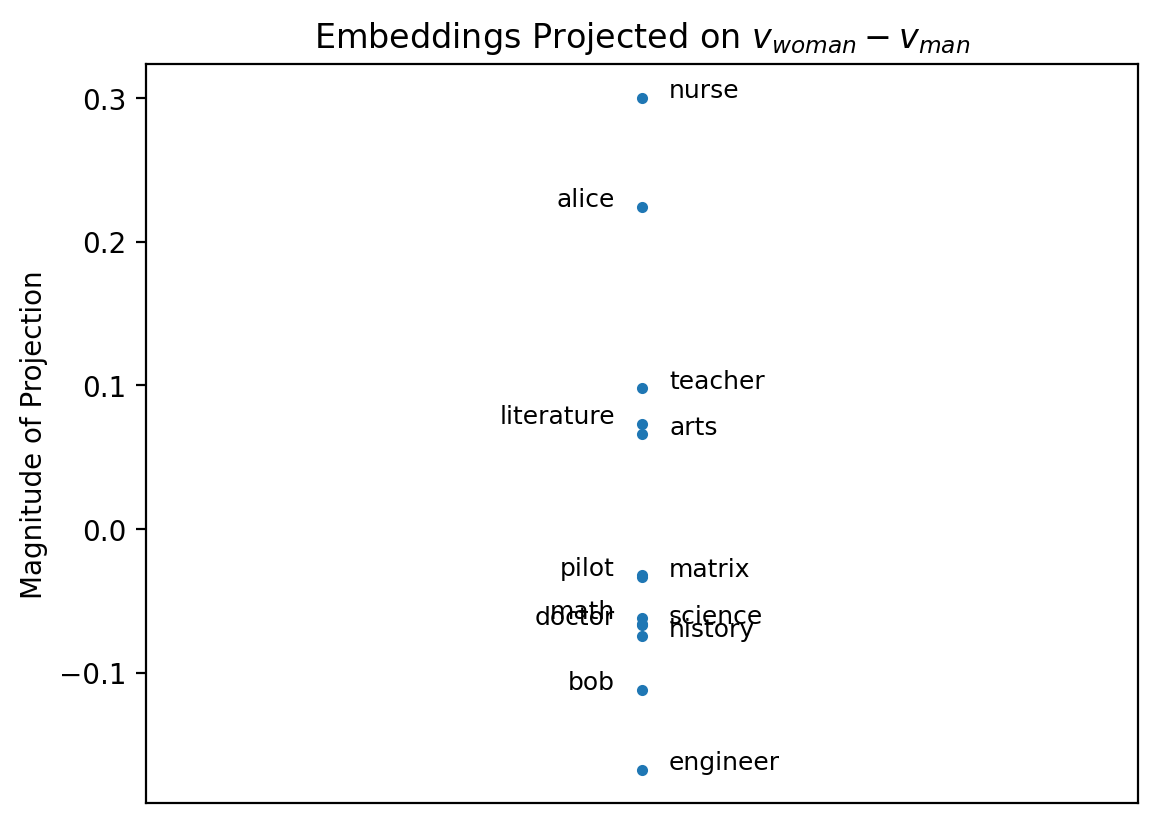

In [88]:
plot_projections(
    EMBEDDINGS,
    [
        "math",
        "matrix",
        "history",
        "nurse",
        "doctor",
        "pilot",
        "teacher",
        "engineer",
        "science",
        "arts",
        "literature",
        "bob",
        "alice",
    ],
)

The embeddings (correctly) represent existing societal stereotypes and gender norms: ENGINEERS ARE MEN and TEACHERS ARE WOMEN, WOMEN ARE GOOD AT ART and MEN ARE GOOD AT SCIENCE, etc.

This is an issue because people need and expect algorithmic choices and mathematical models to be unbiased, objective sources of information, but when trained on human behavior they naturally exhibit the same biases that the emulated humans did, making them similarly subjective. A naïve system that simply rates matches based on the magnitude of the dot-product between a job description embedding and a candidate bio embedding would then be more likely to suggest that women become teachers and men become engineers, or that men named "Ashley" be teachers more than other men. This will lead to missing appropriate candidates, which is bad for companies looking for talent, as well as for workers not being given the opportunities that they need to excel in the career of their choice. If one values class mobility, workplace satisfaction or diversity, or human happiness generally, then this is a big issue, particularly at scale.

<div class="custom-assignment-text">

* iii (3 points) Propose one method of mitigating the problem discussed in the previous part. There are many acceptable answers, and this is an ongoing area of research, so be creative and do not worry about making your answer overly rigorous. [Hint: If you need inspiration, see the original paper that surfaced this issue.]

</div>

My first idea to eliminate the bias would simply be to subtract $\mathbf{v_{woman}} - \mathbf{v_{man}}$ as well as $\mathbf{v_{man}} - \mathbf{v_{woman}}$ from word embeddings which have a large projection on them. The bias that we are trying to eliminate, and therefore the list of embeddings that need to be adjusted, would be highly application-dependent. Additionally, how this should be done is likely to be fraught with disagreement.

<div class="custom-assignment-text">

e. In this question we will explore in more depth the property that directions in the embedded space correspond to semantic or syntactic concepts.

</div>

<div class="custom-assignment-text">

* i (4 points) First, we will define a similarity metric for words: the similarity of two words will be defined as the cosine-similarity between their embeddings. As all the word embedding vectors have unit $\ell_2$ norm, the cosine similarity between two words $i$ and $j$ with embeddings $w_i$ and $w_j$ is equal to the inner product $\langle w_{i}, w_{j} \rangle$. Now that we have a similarity metric defined, we can have some fun with these embeddings by querying for the closest word to any word we like! Using this definition of similarity, what are the most similar words to “stanford”?

</div>

In [131]:
markdown("#### Top-10 most similar words to \"stanford\":")
for word in EMBEDDINGS.get_n_closest("stanford", 10):
    markdown(f"* {word}")

#### Top-10 most similar words to "stanford":

* harvard

* cornell

* ucla

* yale

* princeton

* penn

* auburn

* mit

* berkeley

* tech

<div class="custom-assignment-text">

* ii (10 points) Because word embeddings capture semantic and syntactic concepts, they can be used to solve word analogy tasks. For example, consider an analogy question— "man is to woman as king is to \____", where the goal is to fill in the blank space. This can be solved by finding the word whose embedding is closest to $w_{woman} − w_{man} + w_{king}$ in cosine similarity. You can do this by a nearest neighbor search across the entire dictionary—excluding the three words *man*, *woman*, *king* which already appear in the analogy as they cannot be valid answers to the question. Here $w_i$ represents the word embedding for the word $i$. <br>We have provided a dataset, `analogy_task.txt`, which tests the ability of word embeddings to answer analogy questions. Using the cosine similarity metric, find and report the accuracy of the word embedding approach to solving the analogy task. Comment on the results–which analogies seemed especially difficult for this approach?

</div>

In [237]:
ANALOGIES = load_analogy_data()

In [238]:
def report_analogy_predictions():
    predictions = []
    for row in tqdm(ANALOGIES.itertuples(), total=len(ANALOGIES)):
        p = EMBEDDINGS.solve_analogy(row.a, row.b, row.c)
        predictions.append(p)
    data = ANALOGIES.assign(predicted=predictions)
    
    correct = (data['predicted'] == data['d']).sum()
    markdown(f"* Got {correct}/{len(data)} analogies correct")
    return data

ANALOGY_PREDICTION_DATA = report_analogy_predictions()

  0%|          | 0/5585 [00:00<?, ?it/s]

* Got 106/5585 analogies correct

1.8% accuracy is dismal :( I see many cases where it successfully predicts gender-based analogies, but mostly it just plain fails at everything.

In [233]:
markdown("####  A Sample of the correctly predicted analogical relationships")
ANALOGY_PREDICTION_DATA[ANALOGY_PREDICTION_DATA['predicted'] == ANALOGY_PREDICTION_DATA['d']].sample(60)

####  A Sample of the correctly predicted analogical relationships

,a,b,c,d,predicted
2319,slow,slower,low,lower,lower
4816,bird,birds,dream,dreams,dreams
4858,car,cars,dream,dreams,dreams
4907,child,children,machine,machines,machines
5022,dollar,dollars,child,children,children
1369,grandson,granddaughter,he,she,she
5555,work,works,estimate,estimates,estimates
4960,color,colors,cloud,clouds,clouds
5171,lion,lions,color,colors,colors
5275,road,roads,cloud,clouds,clouds


In [234]:
markdown("####  A Sample of the incorrectly predicted analogical relationships")
ANALOGY_PREDICTION_DATA[ANALOGY_PREDICTION_DATA['predicted'] != ANALOGY_PREDICTION_DATA['d']].sample(60)

####  A Sample of the incorrectly predicted analogical relationships

,a,b,c,d,predicted
149,moscow,russia,madrid,spain,barcelona
2909,play,playing,go,going,come
5,athens,greece,helsinki,finland,stockholm
2487,high,highest,fast,fastest,slow
2333,small,smaller,good,better,excellent
1475,prince,princess,sons,daughters,brother
245,athens,greece,budapest,hungary,helsinki
10,athens,greece,ottawa,canada,montreal
1665,possible,possibly,safe,safely,acceptable
4245,implementing,implemented,going,went,putting


<div class="custom-assignment-text">

* iii (Bonus 5 points) Your goal is to now improve the score of the word embeddings on the analogy task. Feel free to try any alternative scheme for learning word embeddings, but using only the cooccurrence matrix we have provided. Discuss the approaches you tried, what informed the choices, and the results they obtained. Showing that certain approaches obtain a poor accuracy is also valuable too. Your score will be based on a combination of the discussion and the best accuracy you obtain

</div>

Hypothesis 1: if we calculate $\mathbf{v}$ by averaging the embedding differences for several identical analogies (IS THE CAPITAL OF, IS THE FEMALE EQUIVALENT OF, etc.), we may obtain an overall more correct distance embedding. Let's try it with capitals, which our original scheme got all wrong. We'll do a leave-one-out scheme, meaning that we'll average the distance between the country/capital embedding pairs and then add the country whose capital we want to find.

In [278]:
def test_averaging_analogy_hypothesis():
    capital_examples = [("paris", "france"),
        ("rome", "italy"),
        ("stockholm", "sweden"),
        ("tokyo", "japan"),
        ("athens", "greece"),
        ("bangkok", "thailand"),
        ("beijing", "china"),
        ("berlin", "germany"),
        ("cairo", "egypt"),
        ("canberra", "australia"),
        ("helsinki", "finland"),
        ("london", "england"),
        ("madrid", "spain"),
        ("moscow", "russia"),
        ("oslo", "norway")]
    
    embedding_diffs = []
    for i in range(len(capital_examples)):
        a, b = capital_examples[i]
        a_embedding = EMBEDDINGS.get_embedding(a)
        b_embedding = EMBEDDINGS.get_embedding(b)
        embedding_diffs.append(a_embedding - b_embedding)
    
    for i in range(len(capital_examples)):
        a, b = capital_examples[i]
        a_index = EMBEDDINGS.dictionary.index[EMBEDDINGS.dictionary == a][0]
        
        embedding_diffs_series = pd.Series(embedding_diffs)
        # don't use embedding diff of relationship we're trying to predict
        embedding_diffs_series.drop(i)
        avg_diff_embedding = embedding_diffs_series.sum() / (len(capital_examples) - 1)
        search_embedding = avg_diff_embedding + EMBEDDINGS.get_embedding(a)
    
        sims = search_embedding.dot(EMBEDDINGS.embeddings.T)
        sims.drop(a_index, inplace=True)
        closest_idx = sims.idxmax()
        closest_word = EMBEDDINGS.dictionary[closest_idx]
        print(f"{a} is the capital of {b} (predicted {closest_word})")

test_averaging_analogy_hypothesis()

paris is the capital of france (predicted brussels)
rome is the capital of italy (predicted athens)
stockholm is the capital of sweden (predicted oslo)
tokyo is the capital of japan (predicted seoul)
athens is the capital of greece (predicted istanbul)
bangkok is the capital of thailand (predicted seoul)
beijing is the capital of china (predicted seoul)
berlin is the capital of germany (predicted frankfurt)
cairo is the capital of egypt (predicted istanbul)
canberra is the capital of australia (predicted brisbane)
helsinki is the capital of finland (predicted oslo)
london is the capital of england (predicted dublin)
madrid is the capital of spain (predicted barcelona)
moscow is the capital of russia (predicted budapest)
oslo is the capital of norway (predicted helsinki)


Aaaand it still got everything 100% wrong. This method did not help at all.

In [279]:
assert_globals_clean()

<div class="custom-assignment-text">

# Part 2: SVD for image compression

Download http://web.stanford.edu/class/cs168/p5_image.gif. It is a 1600 × 1170, black and white drawing of Alice conversing with a Cheshire Cat. We will think of this image as a 1600 × 1170 matrix, with each black pixel represented as a 0, and each white pixel represented as a 1. We will observe this matrix under various approximations induced by its SVD.

</div>

<div class="custom-assignment-text">

* a. (4 points) Before running SVD on Alice, think about what you expect the rank-1 approximation given
by SVD to look like. To guide your thinking, consider the following simpler picture, where black pixels
have value 0. Qualitatively describe the rank-1 approximation (given by SVD) of the following picture
of the moon. Explain your reasoning. [Hint: it might be helpful for you to sketch what you expect the
answer to be—and make sure it is rank-1!]
    
    <figure><center><img src="../../materials/Week 5/moon.png" width=300></center><figcaption>Figure 1: The Moon. Assume this is represented as a matrix of pixel values, with black = 0.</figcaption></figure>

</div>